In [358]:
import pandas as pd
import numpy as np
import datetime as dt

import pickle

from matplotlib import pyplot as plt

plt.style.use('ggplot')

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline


The scikit-learn version is 1.0.2.


In [ ]:
# pip install xgboost

In [359]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [360]:
def calc_VIF(x):
  vif_1 = pd.DataFrame()
  vif_1['variables']=x.columns
  vif_1["VIF"] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]

  return(vif_1)

In [361]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold)), average='macro'))

    scores_table = pd.DataFrame({'f1_macro':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1_macro', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1_macro', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='red', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [362]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [363]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [364]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1_macro',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Загрузка и соединение датасетов**

In [365]:
df = pd.read_csv('./data_train.csv')
df_test = pd.read_csv('./data_test.csv')

In [366]:
df.head(5)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


In [367]:
df = df.drop('Unnamed: 0', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [368]:
df_test.head(5)

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400


In [369]:
df_test = df_test.drop('Unnamed: 0', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [355]:
id_list = df['id'].tolist()
features = pd.DataFrame()
df_iter = pd.read_csv('./features.csv', sep='\t', chunksize=100000, iterator=True)
for iter_count, chunk in enumerate(df_iter, 1):
    filter1 = chunk['id'].isin(id_list)
    features = features.append(chunk[filter1], ignore_index=True)
    print(f'Iter_count: {iter_count}')
    
df = pd.merge_asof(df.sort_values(by=['id']), features.sort_values(by=['id']), on='id', by='buy_time', direction='nearest')

**Обзор тренировочного датасета**

In [370]:
features = None

In [371]:
df.head(5)

,id,vas_id,buy_time,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,30,7.0,1539550800,0.0,204.890029,-106.489112,190.949214,-159.096798,185.531754,-180.20179,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,230.420873,219.09189,-0.000725,-0.016435,-0.107041,-5.41746,1.901479,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,...,-42051.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,9.670541e+08,238.065922,-4.405604e+08,-1.204418e+08,-1.400668,-1.465191,-33.302382,-262.128986,-39.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,-876.69102,-5.368281,-247.110707,-108.409742,-512.437331,-106.617978,-17.295406,-467.373846,-103.770792,-25.996269,-37.630448,-294.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,52,5.0,1544994000,0.0,175.230029,-7.369112,186.699214,12.883202,181.281754,-8.22179,238.15382,189.163903,-6.78366,-30.006538,-2.736081,250.232474,-2.558912,-66.189127,-59.72811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,11.469185,243.495836,-0.094251,-0.001733,-0.009327,-2.082209,-0.799862,-0.00909,2.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,...,-42051.166127,-9238.707081,47.89195,-0.000083,1.377104,-0.00004,1.379228,-0.012257,-0.107878,9.726701e+08,195.695922,-4.405604e+08,1.391594e+09,-11.514461,-1.465191,-33.302382,-255.128986,-36.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,-278.69102,-4.368281,-247.110707,-108.409742,84.562669,-106.617978,-17.295406,-976.373846,-613.770792,-25.996269,-37.630448,-298.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2,121,1.0,1545598800,0.0,-86.199971,-100.969112,-100.140786,-149.336798,-105.558246,-170.44179,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,7.421479,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,...,-42051.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,-5.726695e+08,-58.544078,-4.405604e+08,-1.204418e+08,6.042189,-1.465191,-33.302382,-102.128986,-39.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,3657.30898,2.631719,819.889293,-108.409742,2872.562669,-106.617978,-17.295406,2782.626154,-223.770792,-25.996269,-29.630448,-167.747724,-16.832889,3.305572,-12.175933,0.54386,0.0
3,174,1.0,1537736400,0.0,-94.679971,-406.059112,-108.620786,-458.666798,-114.038246,-479.77179,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-1.058521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,-0.799862,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,...,-42051.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,-5.726695e+08,-58.544078,-4.405604e+08,-1.204418e+08,-17.100668,-1.465191,-33.302382,392.871014,7.227508,-0.364694,-0.133771,-0.209468,10.643495,-109.884564,2253.30898,11.631719,1206.889293,-72.409742,1002.562669,232.382022,-17.295406,-324.373846,-247.770792,-24.996269,-14.630448,141.252276,14.167111,-0.694428,27.824067,-0.45614,0.0
4,184,2.0,1543784400,0.0,-96.799971,-69.199112,-110.740786,-121.806798,-116.158246,-142.91179,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,...,-42051.1

In [372]:
# Из-за ограничения в пямяти будет использоваться выборка из 30000 строк
df = df.sample(30000)

In [374]:
target = 'target'
df = df.drop(['id'], axis=1)

In [375]:
df['buy_time'] = df['buy_time'].apply(lambda timestamp: dt.datetime.fromtimestamp(timestamp))
df['day_of_week'] = pd.to_datetime(df['buy_time'])
df['day_of_week'] = df['buy_time'].dt.day_name()
df = df.drop(['buy_time'], axis=1)

In [376]:
df['day_of_week'].value_counts()

Sunday    30000
Name: day_of_week, dtype: int64

In [377]:
df[target].value_counts()

0.0    27848
1.0     2152
Name: target, dtype: int64

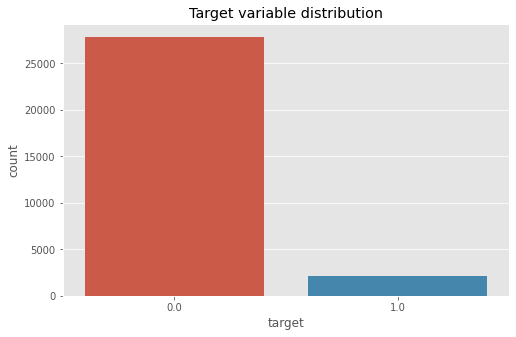

In [378]:
plt.figure(figsize=(8, 5))

sns.countplot(x=target, data=df)

plt.title('Target variable distribution')
plt.show()

In [379]:
base_feature_names = df.columns.drop(target).tolist()
new_feature_names = df.columns.drop([target] + base_feature_names)

**Обзор и преобразование признаков**

In [380]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 75581 to 45302
Columns: 256 entries, vas_id to day_of_week
dtypes: float64(255), object(1)
memory usage: 59.8+ MB


In [381]:
df.isnull().values.sum() > 0

False

пустых значений нет

In [382]:
X_nunique = df.apply(lambda x: x.nunique(dropna=False))
X_nunique.shape

(256,)

In [383]:
f_all = X_nunique.index.tolist()
len(f_all)

256

In [384]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())
f_const

{'139',
 '15',
 '203',
 '216',
 '218',
 '23',
 '24',
 '32',
 '33',
 '75',
 '81',
 '85',
 '95',
 'day_of_week'}

In [385]:
df = df.drop(f_const, axis=1)

In [386]:
binary_cols = set(X_nunique[X_nunique == 2].index.tolist())
binary_cols

{'132',
 '154',
 '192',
 '194',
 '195',
 '196',
 '197',
 '198',
 '199',
 '200',
 '201',
 '202',
 '204',
 '205',
 '206',
 '252',
 '26',
 '27',
 '31',
 '57',
 'target'}

In [387]:
category_col = set(X_nunique[X_nunique.between(3, 11)].index.tolist())
category_col_list = list(category_col)
category_col

{'131',
 '133',
 '155',
 '16',
 '17',
 '177',
 '179',
 '180',
 '193',
 '212',
 '220',
 '221',
 '28',
 '29',
 '30',
 '35',
 '65',
 '84',
 '86',
 '87',
 '88',
 'vas_id'}

*Создадим словарь из датафреймов со средними значениями категориальных признаков и сгенерируем новые признаки*

In [388]:
dict_code_mean = {col: pd.DataFrame() for col in category_col}
for col in category_col:
    col_name = str(col) + '_mean_group'
    dict_code_mean[col] = df.groupby([col], as_index=False).agg({'target':'mean'}).rename(columns={'target':col_name})
    df = df.merge(dict_code_mean[col], on=[col], how='left')
df = df.drop(category_col, axis=1)

In [389]:
f_numeric = list(set(f_all) - set(category_col) - set(binary_cols) - (f_const))

In [390]:
print('f_all:', len(f_all))
print()
print('f_const:', len(f_const))
print('f_binary:', len(binary_cols))
print('f_categorical:', len(category_col))
print('f_numeric:', len(f_numeric))

f_all: 256

f_const: 14
f_binary: 21
f_categorical: 22
f_numeric: 199


In [391]:
df.head(3)

,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,18,19,20,21,22,25,26,27,31,34,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,30_mean_group,65_mean_group,212_mean_group,17_mean_group,155_mean_group,28_mean_group,131_mean_group,86_mean_group,133_mean_group,88_mean_group,220_mean_group,177_mean_group,193_mean_group,vas_id_mean_group,29_mean_group,221_mean_group,87_mean_group,16_mean_group,180_mean_group,84_mean_group,35_mean_group,179_mean_group
0,0.0,425.400029,368.440888,415.699214,345.503202,410.281754,324.39821,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,399.910873,391.63189,-5.41746,49.871479,-9.700815,-10.744164,-0.094251,50.967791,0.200138,-0.00909,-0.001884,-2.65939,3.879235,412.973041,-2551.361304,-1186.661345,-1364.699964,-89.504287,-119.724355,146.871311,91.047476,55.823836,-7.896282,-6.237683,-10.717958,-28.571103,...,-109.884564,-503.69102,-5.368281,-247.110707,-108.409742,-139.437331,-106.617978,-17.295406,-977.373846,-613.770792,-25.996269,-37.630448,-298.747724,-21.832889,-0.694428,-8.175933,-0.45614,1.0,0.071281,0.07147,0.072339,0.071745,0.071745,0.071064,0.074595,0.071738,0.077353,0.071757,0.071856,0.071781,0.063161,0.018473,0.071064,0.071705,0.071767,0.071741,0.071757,0.071726,0.071745,0.071757
1,0.0,-2.889971,-43.149112,-4.250786,-15.426798,-9.668246,-36.53179,-16.08618,-22.696097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-36.929127,-6.44811,-5.41746,19.661479,-1.360815,-10.744164,-0.094251,-2.082209,-0.799862,-0.00909,-0.001884,-2.65939,7.769235,-92.026959,-2752.238254,-996.563687,-1755.674564,-89.504287,-119.724355,141.087981,69.864146,71.223846,-7.896282,-7.725315,-10.717958,-28.536136,...,-109.884564,-807.69102,-5.368281,-207.110707,-87.409742,-504.437331,-105.617978,-17.295406,-977.373846,-613.770792,-23.996269,56.369552,-297.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0,0.071281,0.07147,0.072339,0.071745,0.071745,0.071064,0.074595,0.071738,0.071319,0.071757,0.071856,0.071781,0.076588,0.017170,0.071064,0.071705,0.071767,0.071741,0.071757,0.071726,0.071745,0.071757
2,0.0,-96.799971,-26.819112,-110.740786,-79.426798,-116.158246,-100.53179,-16.08618,316.283903,-6.78366,351.353462,-2.736081,-4.007526,-2.558912,-66.189127,-77.51811,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-2.082209,-0.799862,-0.00909,-0.001884,-2.65939,-0.700765,-192.026959,943.503896,2699.178463,-1755.674564,-89.504287,-119.724355,-119.662019,-54.602524,-65.059494,-7.896282,-7.997875,-10.717958,-28.544336,...,-109.884564,-448.69102,-5.368281,-247.110707,319.590258,-512.437331,-106.617978,-17.295406,1730.626154,1930.229208,-25.996269,-37.630448,73.252276,21.167111,-0.694428,-12.175933,-0.45614,0.0,0.075173,0.07147,0.072339,0.071745,0.071745,0.078261,0.065414,0.071738,0.067479,0.071757,0.071856,0.071781,0.069407,0.247343,0.075797,0.071705,0.071767,0.071741,0.071757,0.071726,0.071745,0.071757


**Проверка признаков на мультиколлинеарность с помощью variance_inflation_factor**

In [392]:
df_vif = df[f_numeric]
df_columns_vif = df_vif.columns.to_list()

In [393]:
scaler = StandardScaler()

df_norm_vif = df_vif.copy()
df_norm_vif[df_columns_vif] = scaler.fit_transform(df_norm_vif[df_columns_vif])

df_vif = df_norm_vif.copy()

In [394]:
x=df_vif.iloc[:,:-1]
vif_1 = calc_VIF(x)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [395]:
select_columns = list(np.where(vif_1["VIF"] > 5)[0])

In [396]:
select_columns = [str(i) for i in select_columns]

In [397]:
len(select_columns)

105

*Отобрано 110 мультиколлинеарных признака, которые можно не использовать для прогнозирования*

**Отбор признаков для прогнозирования**

In [398]:
FEATURE_NAMES_SELECTED = df.columns.drop(target).tolist()
FEATURE_NAMES_SELECTED = list(set(FEATURE_NAMES_SELECTED) - set(select_columns))

**Нормализация данных**

In [399]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[f_numeric] = scaler.fit_transform(df_norm[f_numeric])

df = df_norm.copy()

**Разбиение на train и test**

In [400]:
X = df[FEATURE_NAMES_SELECTED]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

**Балансировка целевой переменной**

In [401]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target)
    
df_balanced[target].value_counts()

0.0    20879
1.0    19452
Name: target, dtype: int64

In [402]:
X_train = df_balanced.drop(columns=target)
y_train = df_balanced[target]

### Построение и оценка базовых моделей

In [403]:
df_metrics = pd.DataFrame(columns=['model', 'test_f1_score'])

*k ближайших соседей*

In [404]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93     20879
         1.0       0.88      1.00      0.94     19452

    accuracy                           0.94     40331
   macro avg       0.94      0.94      0.94     40331
weighted avg       0.94      0.94      0.94     40331

TEST

              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87      6969
         1.0       0.10      0.25      0.14       531

    accuracy                           0.78      7500
   macro avg       0.52      0.53      0.51      7500
weighted avg       0.88      0.78      0.82      7500

CONFUSION MATRIX

col_0    0.0   1.0
target            
0.0     5724  1245
1.0      399   132


In [405]:
test_f1_score = f1_score(y_test, y_test_pred, average='macro')
new_row = {'model':'model_knn', 'test_f1_score': test_f1_score}
df_metrics = df_metrics.append(new_row, ignore_index=True)

**Бустинговые алгоритмы**

*XGBoost*

In [406]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86     20879
         1.0       0.85      0.84      0.85     19452

    accuracy                           0.85     40331
   macro avg       0.85      0.85      0.85     40331
weighted avg       0.85      0.85      0.85     40331

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92      6969
         1.0       0.33      0.84      0.47       531

    accuracy                           0.86      7500
   macro avg       0.66      0.86      0.70      7500
weighted avg       0.94      0.86      0.89      7500

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     6039  930
1.0       83  448


In [407]:
test_f1_score = f1_score(y_test, y_test_pred, average='macro')
new_row = {'model':'model_xgb', 'test_f1_score': test_f1_score}
df_metrics = df_metrics.append(new_row, ignore_index=True)

*LightGBM*

In [408]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94     20879
         1.0       0.91      0.97      0.94     19452

    accuracy                           0.94     40331
   macro avg       0.94      0.94      0.94     40331
weighted avg       0.94      0.94      0.94     40331

TEST

              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93      6969
         1.0       0.35      0.77      0.48       531

    accuracy                           0.88      7500
   macro avg       0.67      0.83      0.71      7500
weighted avg       0.94      0.88      0.90      7500

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     6213  756
1.0      123  408


In [409]:
test_f1_score = f1_score(y_test, y_test_pred, average='macro')
new_row = {'model':'model_lgbm', 'test_f1_score': test_f1_score}
df_metrics = df_metrics.append(new_row, ignore_index=True)

*CatBoost*

In [410]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97     20879
         1.0       0.94      0.99      0.97     19452

    accuracy                           0.97     40331
   macro avg       0.97      0.97      0.97     40331
weighted avg       0.97      0.97      0.97     40331

TEST

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94      6969
         1.0       0.38      0.72      0.49       531

    accuracy                           0.90      7500
   macro avg       0.68      0.82      0.72      7500
weighted avg       0.93      0.90      0.91      7500

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     6333  636
1.0      148  383


In [411]:
test_f1_score = f1_score(y_test, y_test_pred, average='macro')
new_row = {'model':'model_catb', 'test_f1_score': test_f1_score}
df_metrics = df_metrics.append(new_row, ignore_index=True)

In [413]:
df_metrics

,model,test_f1_score
0,model_knn,0.506396
1,model_xgb,0.695987
2,model_lgbm,0.707675
3,model_catb,0.717952


**Выбор лучшей модели и подбор гиперпараметров**

In [265]:
# XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
#        gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
#        min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
#        objective='binary:logistic', reg_alpha=0, reg_lambda=1,
#        scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [266]:
final_model = catb.CatBoostClassifier(silent=True, random_state=21)

*Подбор гиперпараметров*

In [160]:
params = {'n_estimators':[100, 500, 1000], 
          'max_depth':[5, 10, 15],
          'learning_rate':[0.01, 0.1]}

In [161]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [162]:
%%time

gs = GridSearchCV(final_model, params, scoring='f1_macro', cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

CPU times: user 41.4 s, sys: 940 ms, total: 42.3 s
Wall time: 21min 53s


In [163]:
gs.best_params_

{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 1000}

In [164]:
gs.best_score_

0.9797430916002955

**Обучение и оценка финальной модели**

In [417]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=100, max_depth=10, silent=True, 
                                      learning_rate=0.1, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97     20879
         1.0       0.94      0.99      0.97     19452

    accuracy                           0.97     40331
   macro avg       0.97      0.97      0.97     40331
weighted avg       0.97      0.97      0.97     40331

TEST

              precision    recall  f1-score   support

         0.0       0.98      0.91      0.94      6969
         1.0       0.38      0.72      0.49       531

    accuracy                           0.90      7500
   macro avg       0.68      0.82      0.72      7500
weighted avg       0.93      0.90      0.91      7500

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     6333  636
1.0      148  383
CPU times: user 1min 22s, sys: 1.12 s, total: 1min 23s
Wall time: 42.8 s


**Подбор оптимального размера выборки, кривая обучения**

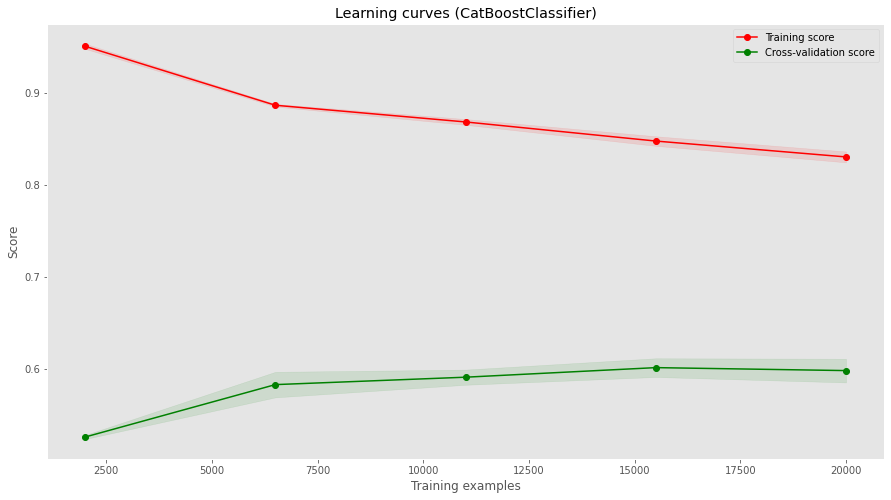

In [418]:
show_learning_curve_plot(final_model, X, y)

**Выбор порога вероятности для определения класса**

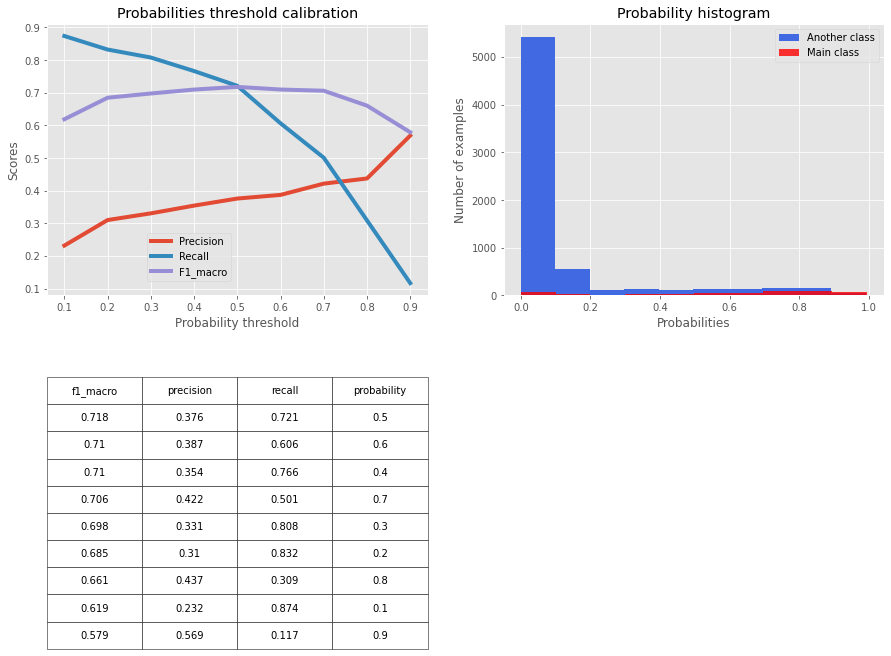

In [419]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

**Важность признаков**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


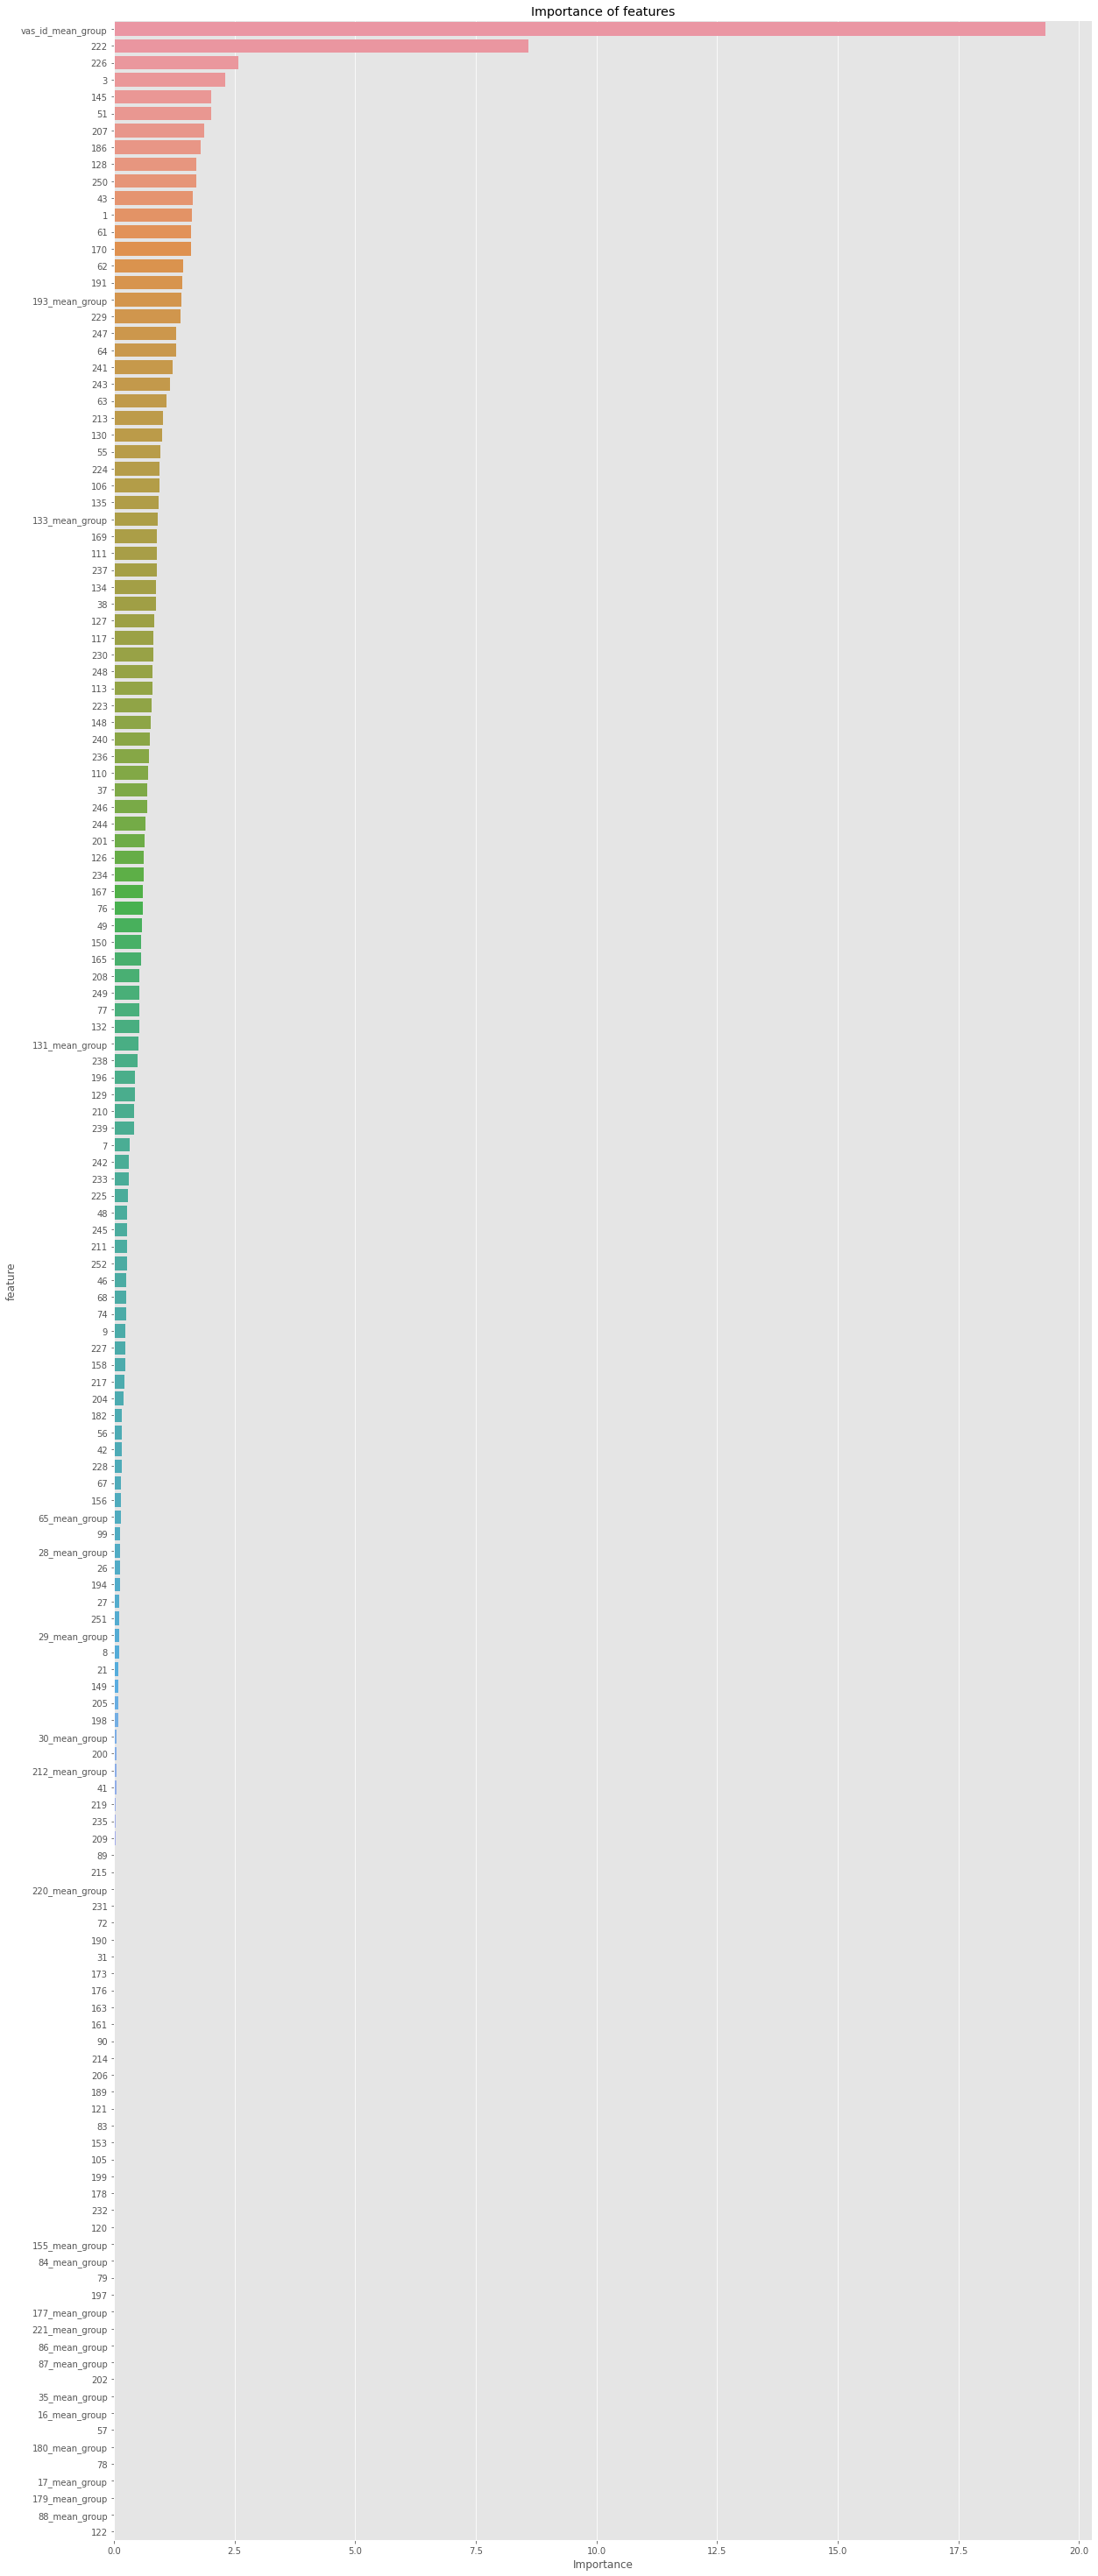

In [420]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=100)

**Финальная модель**

In [421]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=100, max_depth=10, silent=True, 
                                      learning_rate=0.1, random_state=21)

final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97     20879
         1.0       0.94      0.99      0.97     19452

    accuracy                           0.97     40331
   macro avg       0.97      0.97      0.97     40331
weighted avg       0.97      0.97      0.97     40331

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94      6969
         1.0       0.37      0.69      0.48       531

    accuracy                           0.89      7500
   macro avg       0.67      0.80      0.71      7500
weighted avg       0.93      0.89      0.91      7500

CONFUSION MATRIX

col_0    0.0  1.0
target           
0.0     6340  629
1.0      165  366
CPU times: user 1min 12s, sys: 2.01 s, total: 1min 14s
Wall time: 43.7 s


In [422]:
y_train_pred_proba = final_model.predict_proba(X_train[important_features_top])

y_test_pred_proba = final_model.predict_proba(X_test[important_features_top])

In [423]:
y_train_pred = np.where(y_train_pred_proba[:, 1] >= 0.7, 1, 0)
y_test_pred = np.where(y_test_pred_proba[:, 1] >= 0.7, 1, 0)

f1_train = f1_score(y_train, y_train_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')
print(f'f1_macro на train {f1_train}')
print(f'f1_macro на test {f1_test}')

f1_macro на train 0.9739254689032235
f1_macro на test 0.7045045045045044


**Сохранение финальной модели**

In [437]:
with open('./drive/My Drive/Megafon/final_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

### Предсказание класса с помощью итоговой модели


In [333]:
df_test = pd.read_csv('./data_test.csv')

In [334]:
df_test.head(5)

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400


In [335]:
df_test = df_test.drop('Unnamed: 0', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [98]:
df_test

,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000
2,1099444,2.0,1546808400
3,1343255,5.0,1547413200
4,1277040,2.0,1546808400
...,...,...,...
71226,2502453,5.0,1548018000
71227,1693213,2.0,1548018000
71228,1891350,2.0,1548018000
71229,2437172,2.0,1548018000


In [425]:
id_list = df_test['id'].tolist()
features = pd.DataFrame()
df_iter = pd.read_csv('./features.csv', sep='\t', chunksize=100000, iterator=True)
for iter_count, chunk in enumerate(df_iter, 1):
    filter1 = chunk['id'].isin(id_list)
    features = features.append(chunk[filter1], ignore_index=True)
    print(f'Iter_count: {iter_count}')
df_sort_test = pd.merge_asof(df_test.sort_values(by=['id']), features.sort_values(by=['id']), on='id', by='buy_time', direction='nearest')

In [426]:
df_sort_test

,id,vas_id,buy_time,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,55,2.0,1547413200,2266581,-23.859971,-105.359112,-37.800786,-153.726798,-43.218246,-174.83179,-16.08618,-59.146097,-6.78366,-28.753252,-2.736081,-4.007526,-2.558912,6.750873,-4.57811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,...,-41231.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,9.752621e+08,-48.124078,1.062357e+09,-1.204418e+08,2.024332,-1.465191,-33.302382,-215.128986,-32.772492,-0.364694,-0.133771,-0.209468,-28.356505,-109.884564,-868.69102,-3.368281,-246.110707,-105.409742,-510.437331,-89.617978,-17.295406,-977.373846,-613.770792,-24.996269,48.369552,-244.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0
1,64,4.0,1548018000,3102545,-93.799971,-337.249112,-107.740786,-360.686798,-113.158246,-381.79179,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-76.01811,-0.000725,-0.016435,-0.107041,-5.41746,-1.678521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-0.582209,0.200138,-0.00909,0.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,...,-42051.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,-5.726695e+08,-58.544078,-4.405604e+08,-1.204418e+08,-10.684001,-1.465191,-33.302382,-108.128986,-28.772492,-0.364694,-0.133771,-0.209468,-25.356505,-109.884564,5639.30898,3.631719,2654.889293,280.590258,2702.562669,-54.617978,-17.295406,934.626154,-611.770792,-25.996269,3571.369552,-120.747724,25.167111,-0.694428,-12.175933,-0.45614,1.0
2,151,2.0,1547413200,2266581,-23.859971,-105.359112,-37.800786,-153.726798,-43.218246,-174.83179,-16.08618,-59.146097,-6.78366,-28.753252,-2.736081,-4.007526,-2.558912,6.750873,-4.57811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,...,-41231.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,9.752621e+08,-48.124078,1.062357e+09,-1.204418e+08,2.024332,-1.465191,-33.302382,-215.128986,-32.772492,-0.364694,-0.133771,-0.209468,-28.356505,-109.884564,-868.69102,-3.368281,-246.110707,-105.409742,-510.437331,-89.617978,-17.295406,-977.373846,-613.770792,-24.996269,48.369552,-244.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0
3,274,4.0,1548018000,3102545,-93.799971,-337.249112,-107.740786,-360.686798,-113.158246,-381.79179,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-76.01811,-0.000725,-0.016435,-0.107041,-5.41746,-1.678521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-0.582209,0.200138,-0.00909,0.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,...,-42051.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,-5.726695e+08,-58.544078,-4.405604e+08,-1.204418e+08,-10.684001,-1.465191,-33.302382,-108.128986,-28.772492,-0.364694,-0.133771,-0.209468,-25.356505,-109.884564,5639.30898,3.631719,2654.889293,280.590258,2702.562669,-54.617978,-17.295406,934.626154,-611.770792,-25.996269,3571.369552,-120.747724,25.167111,-0.694428,-12.175933,-0.45614,1.0
4,274,2.0,1547413200,2266581,-23.859971,-105.359112,-37.800786,-153.726798,-43.218246,-174.83179,-16.08618,-59.146097,-6.78366,-28.753252,-2.736081,-4.007526,-2.558912,6.750873,-4.57811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0

In [ ]:
features = None

In [427]:
df_sort_test = df_sort_test.drop('Unnamed: 0', 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [428]:
for col in category_col:
    df_sort_test = df_sort_test.merge(dict_code_mean[col], on=[col], how='left')

In [429]:
df_sort_test.apply(lambda x: x.fillna(x.mode()),axis=0)

,id,vas_id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,30_mean_group,65_mean_group,212_mean_group,17_mean_group,155_mean_group,28_mean_group,131_mean_group,86_mean_group,133_mean_group,88_mean_group,220_mean_group,177_mean_group,193_mean_group,vas_id_mean_group,29_mean_group,221_mean_group,87_mean_group,16_mean_group,180_mean_group,84_mean_group,35_mean_group,179_mean_group
0,55,2.0,1547413200,-23.859971,-105.359112,-37.800786,-153.726798,-43.218246,-174.83179,-16.08618,-59.146097,-6.78366,-28.753252,-2.736081,-4.007526,-2.558912,6.750873,-4.57811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,...,-109.884564,-868.69102,-3.368281,-246.110707,-105.409742,-510.437331,-89.617978,-17.295406,-977.373846,-613.770792,-24.996269,48.369552,-244.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0,0.071281,0.07147,0.072339,0.071745,0.071745,0.071064,0.074595,0.071738,0.076702,0.071757,0.071856,0.071781,0.073125,0.020921,0.071064,0.071705,0.071767,0.071741,0.071757,0.071726,0.071745,0.071757
1,64,4.0,1548018000,-93.799971,-337.249112,-107.740786,-360.686798,-113.158246,-381.79179,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-76.01811,-0.000725,-0.016435,-0.107041,-5.41746,-1.678521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-0.582209,0.200138,-0.00909,0.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,...,-109.884564,5639.30898,3.631719,2654.889293,280.590258,2702.562669,-54.617978,-17.295406,934.626154,-611.770792,-25.996269,3571.369552,-120.747724,25.167111,-0.694428,-12.175933,-0.45614,1.0,0.075173,0.07147,0.072339,0.071745,0.071745,0.078261,0.074595,0.071738,0.071319,0.071757,0.071856,0.071781,0.071912,0.247343,0.075797,0.071705,0.071767,0.071741,0.071757,0.071726,0.071745,0.071757
2,151,2.0,1547413200,-23.859971,-105.359112,-37.800786,-153.726798,-43.218246,-174.83179,-16.08618,-59.146097,-6.78366,-28.753252,-2.736081,-4.007526,-2.558912,6.750873,-4.57811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,...,-109.884564,-868.69102,-3.368281,-246.110707,-105.409742,-510.437331,-89.617978,-17.295406,-977.373846,-613.770792,-24.996269,48.369552,-244.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0,0.071281,0.07147,0.072339,0.071745,0.071745,0.071064,0.074595,0.071738,0.076702,0.071757,0.071856,0.071781,0.073125,0.020921,0.071064,0.071705,0.071767,0.071741,0.071757,0.071726,0.071745,0.071757
3,274,4.0,1548018000,-93.799971,-337.249112,-107.740786,-360.686798,-113.158246,-381.79179,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-76.01811,-0.000725,-0.016435,-0.107041,-5.41746,-1.678521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-0.582209,0.200138,-0.00909,0.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,...,-109.884564,5639.30898,3.631719,2654.889293,280.590258,2702.562669,-54.617978,-17.295406,934.626154,-611.770792,-25.996269,3571.369552,-120.747724,25.167111,-0.694428,-12.175933,-0.45614,1.0,0.075173,0.07147,0.072339,0.071745,0.071745,0.078261,0.074595,0.071738,0.071319,0.071757,0.071856,0.071781,0.071912,0.247343,0.075797,0.071705,0.071767,0.071741,0.071757,0.071726,0.071745,0.071757
4,274,2.0,1547413200,-23.859971,-105.359112,-37.800786,-153.726798,-43.218246,-174.83179,-16.08618,-59.146097,-6.78366,-28.753252,-2.736081,-4.007526,-2.558912,6.750873,-4.57811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,

In [342]:
df_sort_test[important_features_top] = scaler.fit_transform(df_sort_test[important_features_top])

In [430]:
test_pred_proba = final_model.predict_proba(df_sort_test[important_features_top])
test_pred_proba[:5]

array([[9.99992768e-01, 7.23224744e-06],
       [8.38768366e-01, 1.61231634e-01],
       [9.99992768e-01, 7.23224744e-06],
       [8.38768366e-01, 1.61231634e-01],
       [9.99992768e-01, 7.23224744e-06]])

In [431]:
test_pred_proba = final_model.predict_proba(df_sort_test[important_features_top])
test_pred_proba[:5]

array([[9.99992768e-01, 7.23224744e-06],
       [8.38768366e-01, 1.61231634e-01],
       [9.99992768e-01, 7.23224744e-06],
       [8.38768366e-01, 1.61231634e-01],
       [9.99992768e-01, 7.23224744e-06]])

In [432]:
test_pred = np.where(test_pred_proba[:, 1] >= 0.8, 1, 0)
test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [433]:
answers_test = pd.DataFrame({
       "id" : df_sort_test.id.tolist(),
       "vas_id" : df_sort_test.vas_id.tolist(),
       "buy_time" : df_sort_test.buy_time.tolist(),
       "target" : test_pred.tolist()})
answers_test

,id,vas_id,buy_time,target
0,55,2.0,1547413200,0
1,64,4.0,1548018000,0
2,151,2.0,1547413200,0
3,274,4.0,1548018000,0
4,274,2.0,1547413200,0
...,...,...,...,...
71226,4362676,2.0,1548018000,0
71227,4362677,2.0,1547413200,0
71228,4362697,5.0,1546808400,0
71229,4362712,5.0,1547413200,0


In [434]:
answers_test['target'].value_counts()

0    70127
1     1104
Name: target, dtype: int64

In [435]:
answers_test.to_csv('./drive/My Drive/Megafon/answers_test.csv', index=None)

In [436]:
answers_test = pd.read_csv('./drive/My Drive/Megafon/answers_test.csv')
answers_test

,id,vas_id,buy_time,target
0,55,2.0,1547413200,0
1,64,4.0,1548018000,0
2,151,2.0,1547413200,0
3,274,4.0,1548018000,0
4,274,2.0,1547413200,0
...,...,...,...,...
71226,4362676,2.0,1548018000,0
71227,4362677,2.0,1547413200,0
71228,4362697,5.0,1546808400,0
71229,4362712,5.0,1547413200,0
